### Preview Data

In [56]:
from fastai.vision.all import *
#hide
from fastbook import *

In [57]:
path = Path("../data/usq/train/images")

In [58]:
#fnames = get_image_files(path/"images")
fnames = get_image_files(path)

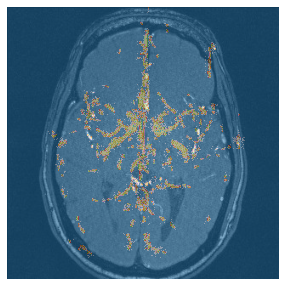

In [59]:
img = PILImage.create(fnames[0])
mask = PILMask.create(str(fnames[0]).replace('images','masks'))
#mask = PILMask.create(str(fnames[0]).replace('mipimages','mipmasks'))
ax = img.show()
ax = mask.show(ctx=ax)

(-0.5, 319.5, 319.5, -0.5)

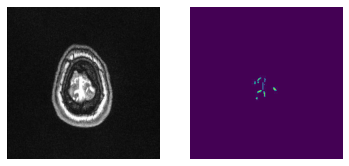

In [77]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(PILImage.create('../data/usq/original_mra/MNI_0590/S580900217.jpg'));
ax[0].axis('off')
ax[1].imshow(PILMask.create('../data/usq/manual_segmentation/MNI_0590/Segmentation0217.jpg'));
ax[1].axis('off')

### Load Data

In [4]:
from fastai.vision.all import *
#hide
from fastbook import *

In [59]:
#path = Path("../data/usq/train/images")
path = Path("../data/usq/imageprojections/all/images")
#path = Path("../data/usq/imageprojections/p1/images")

In [60]:
def get_msk(fname):
    "Grab a mask from a `filename` and adjust the pixels based on `pix2class`"
    fn = str(fname).replace('images','masks')
    msk = np.array(PILMask.create(fn))
    msk = (msk > 100)
    msk = (msk * 1).astype(np.uint8)
    return PILMask.create(msk)

In [61]:
codes = ['Background', 'CV']

In [62]:
def get_y(o):
    return get_msk(o)

In [106]:
#img_size = (320, 320) # p1
#img_size = (247, 320) # p2/p3
#img_size = (247, 639) #p4/p5
img_size = (320, 566) #p6/p7/p8/p9

In [107]:
dblock = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   splitter=RandomSplitter(),
                   get_y=get_y,
                   #item_tfms=Resize((320, 247)))#, method=ResizeMethod.Pad, pad_mode = PadMode.Zeros),
                   item_tfms=Resize(img_size, method=ResizeMethod.Pad, pad_mode = PadMode.Zeros),
                   batch_tfms=[Normalize.from_stats(*imagenet_stats)])
                   #batch_tfms = [RandomResizedCrop((247, 320)), 
                   #          *aug_transforms(mult=1.0, do_flip=True, 
                   #                          max_rotate=30.0, max_zoom=1.5,
                   #                           max_lighting=.8, max_warp=0.3, 
                   #                          p_lighting=.9)])

In [108]:
dsets = dblock.datasets(path)

dls = dblock.dataloaders(path, bs=2)
#dls = dblock.dataloaders(path, bs=8)
dls.vocab = codes

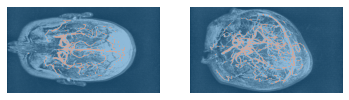

In [109]:
dls.show_batch()

## Modelling

### Dense U-Net

In [22]:
import sys
sys.path.append('/home/msadmin/notebooks/msc8001/src')
from dense_unet import *
from fastai import *

2021-12-03 12:58:52,210 util_log.py[147] INFO Start the program at:msdsvm, 10.0.0.4, with:Load module


Adjust wk folder for notebook failed


In [23]:
encoder = nn.Sequential(*list(models.densenet121().children())[0])
unet = DynamicUnet(encoder, n_classes=2, img_size=(img_size), blur=False, blur_final=False,
                    self_attention=False, y_range=None, norm_type=NormType,
                    last_cross=True,
                    bottle=False)
#print(unet(torch.rand(1,3,224,224)).shape)

    sn        layer     c    w    h               size
2    2         ReLU    64  160  160  (1, 64, 160, 160)
4    4  _DenseBlock   256   80   80   (1, 256, 80, 80)
6    6  _DenseBlock   512   40   40   (1, 512, 40, 40)
8    8  _DenseBlock  1024   20   20  (1, 1024, 20, 20)
11  11  BatchNorm2d  1024   10   10  (1, 1024, 10, 10)


In [24]:
import gc
gc.collect()
torch.cuda.empty_cache()

### Weighted Cross Entropy Loss Function

In [25]:
class CrossEntropyLossFlat(BaseLoss):
    "Same as `nn.CrossEntropyLoss`, but flattens input and target."
    y_int = True
    def __init__(self, *args, axis=-1, **kwargs): super().__init__(nn.CrossEntropyLoss, *args, axis=axis, **kwargs)
    def decodes(self, x):    return x.argmax(dim=self.axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)

In [26]:
weights = torch.tensor([[0.5] + [2.5]]).cuda()
weights

tensor([[0.5000, 2.5000]], device='cuda:0')

In [27]:
loss_func = CrossEntropyLossFlat(weight=weights, axis=1)

In [28]:
# use customer weighted loss function
learn = Learner(dls, unet, loss_func=loss_func, metrics=[foreground_acc, Dice()])
#learn = unet_learner(dls, resnet34, Dice(), metrics=[foreground_acc, Dice()])
learn.summary()

DynamicUnet (Input shape: 2)
Layer (type)         Output Shape         Param #    Trainable 
                     2 x 64 x 160 x 160  
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     2 x 128 x 80 x 80   
Conv2d                                    8192       True      
BatchNorm2d                               256        True      
ReLU                                                           
____________________________________________________________________________
                     2 x 32 x 80 x 80    
Conv2d                                    36864    

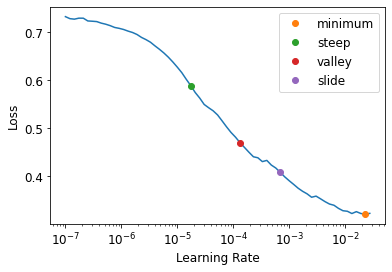

In [111]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [112]:
learn.fit_one_cycle(6, lr_max=3e-4)

epoch,train_loss,valid_loss,foreground_acc,dice,time
0,0.230305,0.112649,0.054894,0.102875,00:06
1,0.142594,0.083253,0.413241,0.543917,00:06
2,0.110953,0.073443,0.701352,0.706376,00:06
3,0.092552,0.071705,0.620305,0.684714,00:06
4,0.081773,0.070275,0.757689,0.727473,00:06
5,0.076195,0.069632,0.695529,0.713793,00:06


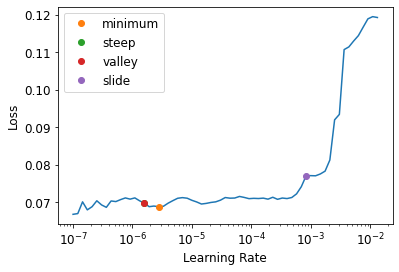

In [113]:
learn.unfreeze()
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [114]:
print(f"Minimum/10: {lrs.minimum:.2e}, steepest point: {lrs.steep:.2e}")

Minimum/10: 2.75e-07, steepest point: 1.58e-06


In [115]:
learn.fit_one_cycle(100, #lrs.steep, 
                    cbs=[ReduceLROnPlateau(monitor='valid_loss', min_delta=0.1, patience=5, min_lr=lrs.minimum),
                                         EarlyStoppingCallback(monitor='dice', min_delta=0.01, patience=15),
                                         SaveModelCallback(monitor='dice', min_delta=0.01)])

epoch,train_loss,valid_loss,foreground_acc,dice,time
0,0.069577,0.070714,0.787976,0.731988,00:07
1,0.069151,0.068865,0.764828,0.735430,00:07
2,0.068924,0.079922,0.448357,0.585473,00:06
3,0.068044,0.066921,0.697482,0.721807,00:06
4,0.068429,0.065244,0.731083,0.737332,00:06
5,0.067977,0.066832,0.748073,0.737891,00:07
6,0.068157,0.077399,0.882105,0.732854,00:07
7,0.068703,0.066499,0.721362,0.730696,00:07
8,0.066454,0.065600,0.709136,0.730623,00:07
9,0.067918,0.068273,0.799518,0.748720,00:06


Better model found at epoch 0 with dice value: 0.7319881584835516.
Epoch 5: reducing lr to 1.6880741495334295e-05
Better model found at epoch 9 with dice value: 0.7487196364749152.
Epoch 10: reducing lr to 4.282060976633484e-05
Epoch 15: reducing lr to 7.226669524855541e-05
Epoch 20: reducing lr to 9.397158846658332e-05
No improvement since epoch 9: early stopping


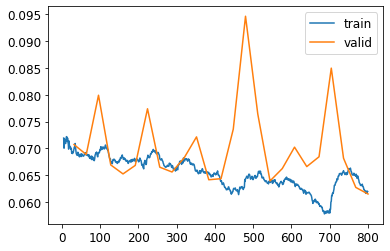

In [116]:
learn.recorder.plot_loss()

## Results

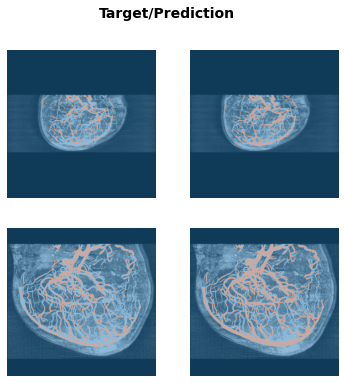

In [79]:
learn.show_results()

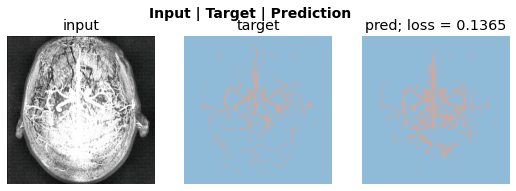

In [80]:
interp = SegmentationInterpretation.from_learner(learn)
interp.plot_top_losses(k=1)

### Save model

In [117]:
#export model as pickle
learn.export('dense_unet_mip_images_model_p6.pkl')